# **Keep your Garden Healthy: Transfer Learning to Classify Garden Plant Diseases.**
![image.png](https://cdn-images-1.medium.com/max/640/0*n0OpV44gZololH4A)

# Background:
In many agricultural communities and villages, the health and productivity of crops and plants are crucial for the livelihood and sustenance of the local population. Plant diseases can lead to substantial crop losses and, subsequently, have a significant economic and social impact on these communities. Traditionally, farmers and agricultural workers have relied on manual observations and experience to detect and manage plant diseases. However, these methods can be time-consuming, error-prone, and often require specific expertise.
# Objective:
The primary objective of building a model to predict village plant diseases is to provide a technology-driven solution that can help farmers and local communities in the following ways:
Early Disease Detection: The model aims to detect plant diseases at an early stage by analyzing visual cues or symptoms. Early detection can enable timely intervention and preventive measures, reducing crop losses.

Increased Crop Yield: By identifying and addressing plant diseases promptly, the model can contribute to higher crop yields, ensuring an adequate food supply for the community and potentially increasing income through surplus crop sales.

Sustainable Agriculture: By preventing or managing plant diseases more efficiently, the model can contribute to sustainable agriculture practices that are environmentally friendly and economically viable.












## Import libs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import Image
from keras.preprocessing.image import img_to_array,load_img
import seaborn as sns



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
width=128
height=128
depth=3
default_image_size = tuple((128,128))
directory_root =r"C:\Users\Rayan\OneDrive\GreatLearning_AI_with_DeepLearning\Introduction_ComputerVision\animal_detection_project\PlantVillage"


# DON'T run this section if you already have the dataset as npy.
##Download dataset and convert it to npy files


In [ ]:

def convert_image_to_array(image_dir, target_size=default_image_size):

    return img_to_array( load_img(image_dir,target_size=(128,128)))/255

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    for root, _, files in os.walk(directory_root):
        print(root)
        for image_file in files:
            if image_file.lower().endswith((".jpg", ".jpeg")):
                image_directory = os.path.join(root, image_file)
                print(image_directory)
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(os.path.basename(os.path.dirname(image_directory)))

    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error: {e}")



In [ ]:
# Convert image_list and label_list to NumPy arrays
images = np.array(image_list)
labels = np.array(label_list)

# Save the NumPy arrays as .npy files
np.save('images.npy', images)
np.save('labels.npy', labels)

print("Arrays saved as images.npy and labels.npy")

Arrays saved as images.npy and labels.npy


In [ ]:
images.shape,labels.shape

((20637, 128, 128, 3), (20637,))

# libraries and Parameter setting


In [ ]:
# import library for nuaral network
from keras.models import Model,Sequential
from keras.applications import vgg16
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils  import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.math import confusion_matrix



In [ ]:
# loading npy files
y=np.load(r'/content/drive/MyDrive/Colab Notebooks/Animal_Detection_YOLOv7/plant_disease_detection/labels.npy')

In [ ]:
y=np.array([x.replace('Tomato__Tomato', 'Tomato') for x in y])

In [ ]:
data=np.load(r'/content/drive/MyDrive/Colab Notebooks/Animal_Detection_YOLOv7/plant_disease_detection/images.npz_compress')


In [ ]:
for key in data.keys():
    print(key)
    print(data[key].shape)


arr_0
(20637, 128, 128, 3)


In [ ]:
X=data['arr_0']


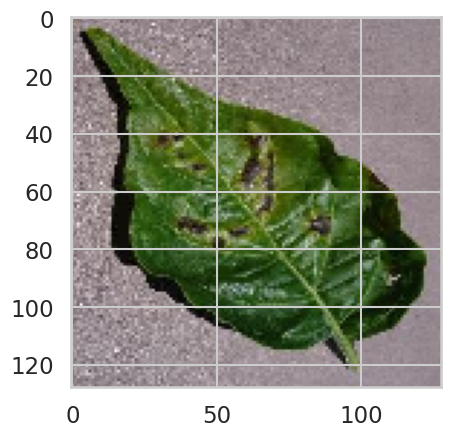

In [ ]:
plt.imshow(X[100,:,:,:])

In [ ]:
unique_values, counts = np.unique(y, return_counts=True)

# Create a dictionary with value counts
value_counts = dict(zip(unique_values, counts))

# Print the value counts
num_values={}
for value, count in value_counts.items():
    num_values[value]=count
    #print(f"{value}: {count}")
print(num_values)

{'Pepper__bell___Bacterial_spot': 997, 'Pepper__bell___healthy': 1477, 'Potato___Early_blight': 1000, 'Potato___Late_blight': 1000, 'Potato___healthy': 152, 'Tomato_Bacterial_spot': 2127, 'Tomato_Early_blight': 1000, 'Tomato_Late_blight': 1909, 'Tomato_Leaf_Mold': 952, 'Tomato_Septoria_leaf_spot': 1771, 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676, 'Tomato_YellowLeaf__Curl_Virus': 3208, 'Tomato__Target_Spot': 1404, 'Tomato_healthy': 1591, 'Tomato_mosaic_virus': 373}


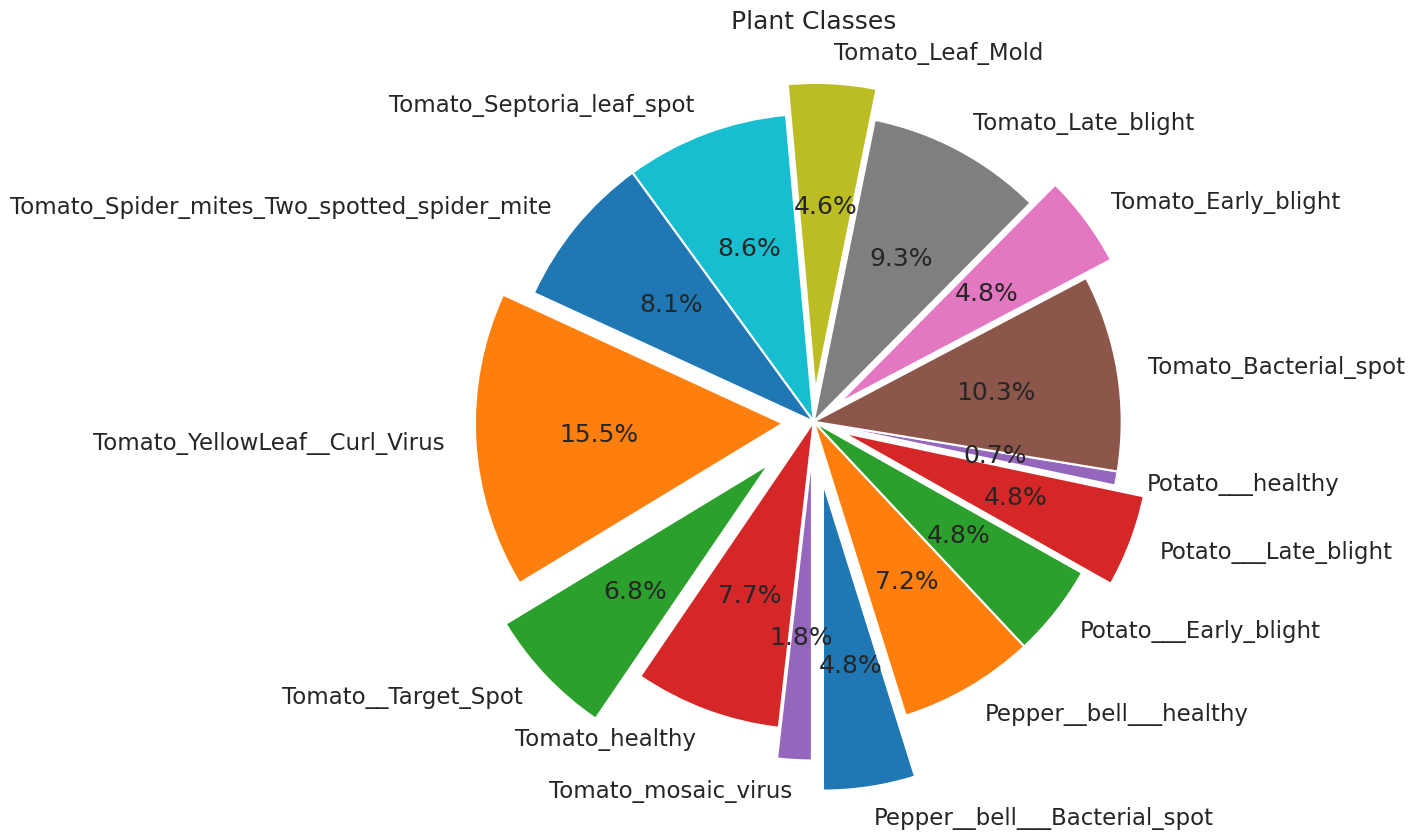

In [ ]:
plt.figure( figsize=(10,10))
plt.pie(counts, labels=unique_values, autopct='%1.1f%%', startangle=270,
        explode=[0.2,0,0,0.1,0,0,0.1,0,0.1,0,0,0.1,0.2,0,0.1])
plt.margins(0.2)
# Add a title
plt.title('Plant Classes')
plt.savefig(os.path.join('/content/drive/MyDrive/Colab Notebooks/Animal_Detection_YOLOv7/plant_disease_detection/', 'plant_village_classes.png'))

# Show the plot
plt.show()

In [ ]:
# split the dataset into train, val, and test
X_temp, X_test, y_temp, y_test = train_test_split(X,y , test_size=0.1, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [ ]:
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [ ]:
enc.classes_

array(['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy',
       'Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight',
       'Tomato_Late_blight', 'Tomato_Leaf_Mold',
       'Tomato_Septoria_leaf_spot',
       'Tomato_Spider_mites_Two_spotted_spider_mite',
       'Tomato_YellowLeaf__Curl_Virus', 'Tomato__Target_Spot',
       'Tomato_healthy', 'Tomato_mosaic_virus'], dtype='<U43')

In [ ]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape

((16715, 15), (1858, 15), (2064, 15))

In [ ]:
# Clearing backend
backend.clear_session()
np.random.seed(42)


###  Learning Rate:
The choice of the learning rate for transfer learning, or any deep learning task, can significantly impact the training process and the model's final performance. There is no one-size-fits-all learning rate value, as it depends on various factors, including the dataset, model architecture, and the specific task. However, here are some general guidelines to help you choose a reasonable learning rate for transfer learning:
In practice, it's common to start with a smaller learning rate and gradually increase it if the model converges slowly. However, there is no universal rule, and you may need to experiment with different learning rates to find the one that works best for your transfer learning task. Regular validation and monitoring are key to making these adjustments effectively.

1. **Fine-Tuning the Learning Rate**: It's common to start with a lower learning rate, such as 0.0001, when fine-tuning a pre-trained model for transfer learning. This is because the lower layers of the pre-trained model have already learned useful features, and you want to make small adjustments to these features.

2. **Learning Rate Schedulers**: Learning rate schedules can be helpful. For example, you can start with a lower learning rate and gradually increase it during training. This can help the model converge quickly initially and then fine-tune the learning rate as training progresses.

3. **Validation and Monitoring**: Keep a close eye on your model's validation performance. You can adjust the learning rate during training based on how the validation loss or accuracy changes. If the model is converging slowly, consider increasing the learning rate. If it's diverging or oscillating, consider decreasing the learning rate.


5. **Size of the Dataset**: The size of your dataset can also influence the learning rate choice. Smaller datasets may benefit from a smaller learning rate to prevent overfitting, while larger datasets may tolerate larger learning rates.

6. **Model Complexity**: The complexity of your model architecture matters. More complex models may require smaller learning rates to avoid overshooting optimal weights.

     

### A table summarizing when to use and when not to use the `ReduceLROnPlateau` callback in transfer learning:

| When to Use `ReduceLROnPlateau`      | When Not to Use `ReduceLROnPlateau`  |
|-------------------------------------|------------------------------------|
| **Large Datasets**: Beneficial when working with large and diverse datasets. | **Small Datasets**: Less necessary for smaller datasets, which may require other strategies to address limitations. |
| **Complex Models**: Useful with complex architectures where convergence or oscillations might be issues. | **Steady Improvement**: Not needed when the model is steadily improving without plateaus in performance. |
| **Fine-Tuning Pre-trained Models**: Effective for making subtle adjustments when fine-tuning pre-trained models. | **Simple Models**: Less useful with simple model architectures or when using features from early layers of pre-trained models. |
| **Training Speed**: Helps stabilize training and saves time when performance plateaus. |  |**bold text**

In [ ]:
#
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)

### Optimizer:
The Adam optimizer is a widely used choice for transfer learning.
It combines the advantages of both the RMSprop and AdaGrad optimizers.
Adam is known for its speed and ability to handle large datasets, making it a good default choice.

In [ ]:
optimizer = Adam(learning_rate=0.001)


### Early Stopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

### Class Weight

In [ ]:
from sklearn.utils import class_weight
y_int=np.argmax(y_train_encoded,axis=1)
class_weights = dict(zip(np.unique(y_int),class_weight.compute_class_weight(
                        class_weight = 'balanced',
                        classes = np.unique(y_int),
                        y = y_int)))
print(class_weights)


{0: 1.3808343659644775, 1: 0.9317168338907469, 2: 1.3757201646090536, 3: 1.3757201646090536, 4: 9.059620596205962, 5: 0.6467401818533566, 6: 1.3757201646090536, 7: 0.7207848210435532, 8: 1.4453091223519239, 9: 0.7765389082462253, 10: 0.8211741586833702, 11: 0.42891968180651785, 12: 0.979203280609256, 13: 0.8644944401344712, 14: 3.6898454746136866}


### Data Augmentaion:

The "rotation_range" parameter determines the maximum degree of rotation that can be applied to an image. Within this range, the augmentation process randomly selects a rotation angle. It's important to note that these transformations do not affect the original class label of the image data. Nevertheless, each transformed image is considered a novel input that the training model hasn't encountered before. This method introduces an alternative form of regularization, which can enhance the model's performance on training datasets.

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=270,
    fill_mode='nearest'
                              )

### Bach Size
The choice of batch size in transfer learning depends on various factors, including your dataset, available computational resources, and the architecture of your model. There is no one-size-fits-all answer, but here are some considerations to help you determine the best batch size for your specific transfer learning task:
*  Dataset Size:

For small datasets, smaller batch sizes are often preferable. Smaller batches allow the model to see more unique examples in each epoch and may help with generalization. A common choice might be 16, 32, or even smaller.

For large datasets, you can use larger batch sizes. This can make better use of computational resources, as well as speed up training. Typical choices for larger datasets might be 64, 128, or more.
*  Model Architecture:

The architecture of your model can influence the batch size. Smaller, simpler models may handle larger batch sizes, while more complex models might require smaller batches to fit in memory.
*  Convergence and Training Time:

Smaller batch sizes can lead to slower convergence but may result in better generalization. Larger batch sizes can speed up training but might require more epochs to achieve similar performance.
*  Noise and Regularization:

Smaller batches introduce more noise into the training process, which can act as a form of regularization. If your model tends to overfit, smaller batches might be beneficial.



In [ ]:
# Epochs
epochs = 30
# Batch size
batch_size =128 # to fast compution

### Check Point
A good application of checkpointing is to serialize your network to disk each time there is an improvement during training. We define an “improvement” to be either a decrease in loss or an increase in accuracy — we’ll set this parameter inside the actual Keras callback.
the out put will be list of weightss files where -000- is epoch number then the validation accuracy :  
weights-000-1.2697.hdf5   
weights-010-0.7987.hdf5    
weights-012-0.8176.hdf5    
#### DO WE NEED TO USE IT.
Sometime.But if you use early stopping with (restore_best = true) and if you only need the model with minimum loss, you don't need to use modelcheckpoint. 


In [ ]:
model_checkpoint = ModelCheckpoint(
    '???_model.h5',  # Specify the file name for the saved model
    monitor='val_accuracy',  # Choose the metric to monitor (e.g., validation accuracy)
    save_best_only=True,  # Save only the best model based on the monitored metric
    mode='max',  # 'max' if monitoring accuracy, 'min' if monitoring loss
    verbose=1  # Display messages when the model is saved
)

### `GlobalAveragePooling2D` and `Flatten` :
Although both can be fed to Fully connected networks but they having diffrent concept and porpose.  
`GlobalAveragePooling2D` and `Flatten` are two different operations used in neural network architectures, particularly in the context of convolutional neural networks (CNNs) for image classification tasks. They serve different purposes, and the choice between them depends on the specific requirements of your model and the problem you are trying to solve.

1. **GlobalAveragePooling2D:**

   - **Purpose**: Global Average Pooling is used to reduce the spatial dimensions (height and width) of the feature maps while retaining the channel (depth) information.
   - **How It Works**: For each channel in the feature map, it calculates the average value of all the spatial locations. This results in a single value per channel.
   - **Advantages**:
     - Reduces the number of parameters in the model, which can help mitigate overfitting.
     - Provides a form of spatial information summarization, making it robust to spatial translations.
   - **Use Cases**: It's commonly used in transfer learning with pre-trained models like MobileNet and Inception, where it helps to reduce the number of parameters while retaining valuable information.

2. **Flatten:**

   - **Purpose**: Flatten is used to convert the 2D feature maps into a 1D vector while preserving all the spatial and channel information.
   - **How It Works**: It simply reshapes the 2D feature map into a 1D vector by stacking all the values in a linear manner.
   - **Advantages**:
     - Maintains the spatial and channel information, which can be important for tasks where spatial relationships matter, such as object localization.
     - Suitable for fully connected layers that expect a 1D input.
   - **Use Cases**: It's commonly used in traditional CNN architectures, especially when followed by one or more fully connected layers for image classification.

**When to Use Each**:

- Use `GlobalAveragePooling2D` when you want to reduce the model's complexity, reduce the risk of overfitting, or when dealing with pre-trained models. It's an effective way to balance computational complexity and accuracy.

- Use `Flatten` when you need to maintain spatial information or when your model architecture requires a 1D vector as input, such as in the case of fully connected layers.



In [ ]:
# Generate a random tensor of shape (100, 28, 28, 3)
x = tf.random.uniform(shape=(100, 28, 28, 3), minval=0, maxval=256, dtype=tf.float32)
print(f"Input shape: {x.shape}")
# Apply the Flatten layer to the input tensor and print the shape
output = Flatten()(x)
print('Flatten:',output.shape)
print('Conv2d GlobalAveragePooling2D=',GlobalAveragePooling2D()(x).shape)

# Create a sequential model to stack layers
model = Sequential()

# Add convolutional layers in a loop
for i in range(5):
    model.add(Conv2D(filters=16,  kernel_size=(3,3), strides=(1,1),padding='same', name=f"conv_{i}"))
    x1 = model(x)
    print(f"Convlayer #{i}shape:{x1.shape}")

# Create a GlobalAveragePooling2D layer
output = GlobalAveragePooling2D()(x1)
print('Conv2d GlobalAveragePooling2D=',output.shape)
print(f"Conv2d flatten =, {Flatten()(x1).shape}")



Input shape: (100, 28, 28, 3)
Flatten: (100, 2352)
Conv2d GlobalAveragePooling2D= (100, 3)
Convlayer #0shape:(100, 28, 28, 16)
Convlayer #1shape:(100, 28, 28, 16)
Convlayer #2shape:(100, 28, 28, 16)
Convlayer #3shape:(100, 28, 28, 16)
Convlayer #4shape:(100, 28, 28, 16)
Conv2d GlobalAveragePooling2D= (100, 16)
Conv2d flatten =, (100, 12544)


# Transfer learning Models:
Transfer learning is like learning from experience. Imagine you're really good at playing the piano, and you've learned to play classical music. Now, you want to learn jazz. Instead of starting from scratch, you can use your piano skills as a foundation. You adapt what you already know (classical music) to help you learn something new (jazz). Transfer learning in machine learning is similar. Models learn from one task and then use that knowledge to help with a new but related task. It's like building on what you've already learned to save time and get better at the new task.

# VGG16:
The VGG16 model is particularly effective for image classification tasks and has been used as a strong baseline architecture in the development of more advanced CNN models. While VGG16's uniform architecture makes it relatively easy to understand and implement, it is also deeper and requires more computational resources compared to earlier CNN models like LeNet and AlexNet.
![image.png](https://miro.medium.com/max/3964/1*ZqkQYVB3_Gw0hjrAMzi6_A.png)
## Architecture:
 VGG16 is a deep neural network with a total of 16 layers, including 13 convolutional layers and 3 fully connected layers. The "16" in its name represents the total number of layers.

* Convolutional Layers: VGG16 is known for its uniform architecture. It uses 3x3 convolutional filters with a small stride (usually 1) for most of its layers. The use of small filters helps capture fine-grained features in the input images.

* Pooling Layers: Max-pooling layers are applied after each group of convolutional layers. These pooling layers reduce the spatial dimensions of the feature maps while preserving the most important information.

* Fully Connected Layers: After the convolutional and pooling layers, VGG16 includes three fully connected layers. The last fully connected layer typically has 1,000 units, making it suitable for image classification tasks with 1,000 classes, such as the ImageNet Large Scale Visual Recognition Challenge.

* Rectified Linear Unit (ReLU) Activation: VGG16 uses ReLU activation functions after each convolutional and fully connected layer. ReLU helps introduce non-linearity into the model, allowing it to learn complex patterns.

* Dropout: Dropout layers are added to the fully connected layers to prevent overfitting. Dropout randomly deactivates a percentage of neurons during training, which helps the model generalize better to unseen data.

In [ ]:
directory_root=r'/content/drive/MyDrive/Colab Notebooks/Animal_Detection_YOLOv7/plant_disease_detection/'

In [ ]:
# Get the Resnet model so we can do transfer learning
vgg_model = vgg16.VGG16(weights= 'imagenet', include_top=False, input_shape= (128,128,3))

for layer in vgg_model.layers[:]:
    layer.trainable = False
# Initializing the model
new_model_vgg = Sequential()
# Adding the convolutional part of the VGG16 model from above
new_model_vgg.add(vgg_model)
new_model_vgg.add(GlobalAveragePooling2D())
new_model_vgg.add(Dense(64, activation='relu'))
# Complete the code to add dropout with dropout_rate=0.1
new_model_vgg.add(Dropout(0.1))
new_model_vgg.add(Dense(32, activation='relu'))
# Complete the code to add dropout with dropout_rate=0.1
new_model_vgg.add(Dropout(0.1))
# Complete the code to add the output layer with 15 neurons and activation functions as softmax since this is a multi-class classification problem
new_model_vgg.add(Dense(15, activation='softmax'))
# Compiling the model
new_model_vgg.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Summary of the model
new_model_vgg.summary()



58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                

In [ ]:
#
history_vgg = new_model_vgg.fit(train_datagen.flow(X_train,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train.shape[0] // batch_size,
                                       validation_data=(X_val,y_val_encoded),
                                       verbose=2,
                        callbacks=[learning_rate_reduction,early_stopping],

                        class_weight=class_weights
                        )

Epoch 1/30
130/130 - 67s - loss: 2.3239 - accuracy: 0.2015 - val_loss: 1.9137 - val_accuracy: 0.4429 - lr: 0.0010 - 67s/epoch - 517ms/step
Epoch 2/30
130/130 - 60s - loss: 1.6430 - accuracy: 0.4419 - val_loss: 1.3904 - val_accuracy: 0.5813 - lr: 0.0010 - 60s/epoch - 458ms/step
Epoch 3/30
130/130 - 61s - loss: 1.3206 - accuracy: 0.5519 - val_loss: 1.1551 - val_accuracy: 0.6405 - lr: 0.0010 - 61s/epoch - 468ms/step
Epoch 4/30
130/130 - 60s - loss: 1.1681 - accuracy: 0.6002 - val_loss: 1.0712 - val_accuracy: 0.6631 - lr: 0.0010 - 60s/epoch - 464ms/step
Epoch 5/30
130/130 - 59s - loss: 1.0570 - accuracy: 0.6316 - val_loss: 1.0091 - val_accuracy: 0.6679 - lr: 0.0010 - 59s/epoch - 457ms/step
Epoch 6/30
130/130 - 58s - loss: 0.9988 - accuracy: 0.6489 - val_loss: 0.9620 - val_accuracy: 0.6706 - lr: 0.0010 - 58s/epoch - 449ms/step
Epoch 7/30
130/130 - 59s - loss: 0.9576 - accuracy: 0.6632 - val_loss: 0.9265 - val_accuracy: 0.6905 - lr: 0.0010 - 59s/epoch - 454ms/step
Epoch 8/30
130/130 - 58s - 

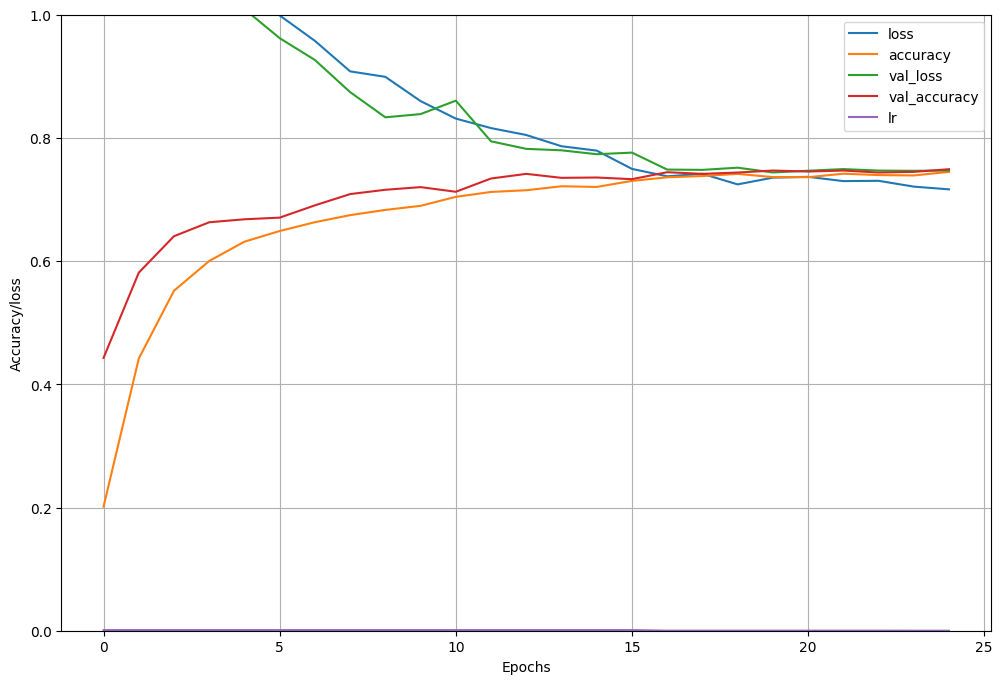

In [ ]:
pd.DataFrame(history_vgg.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.show()


65/65 [==============================] - 4s 59ms/step


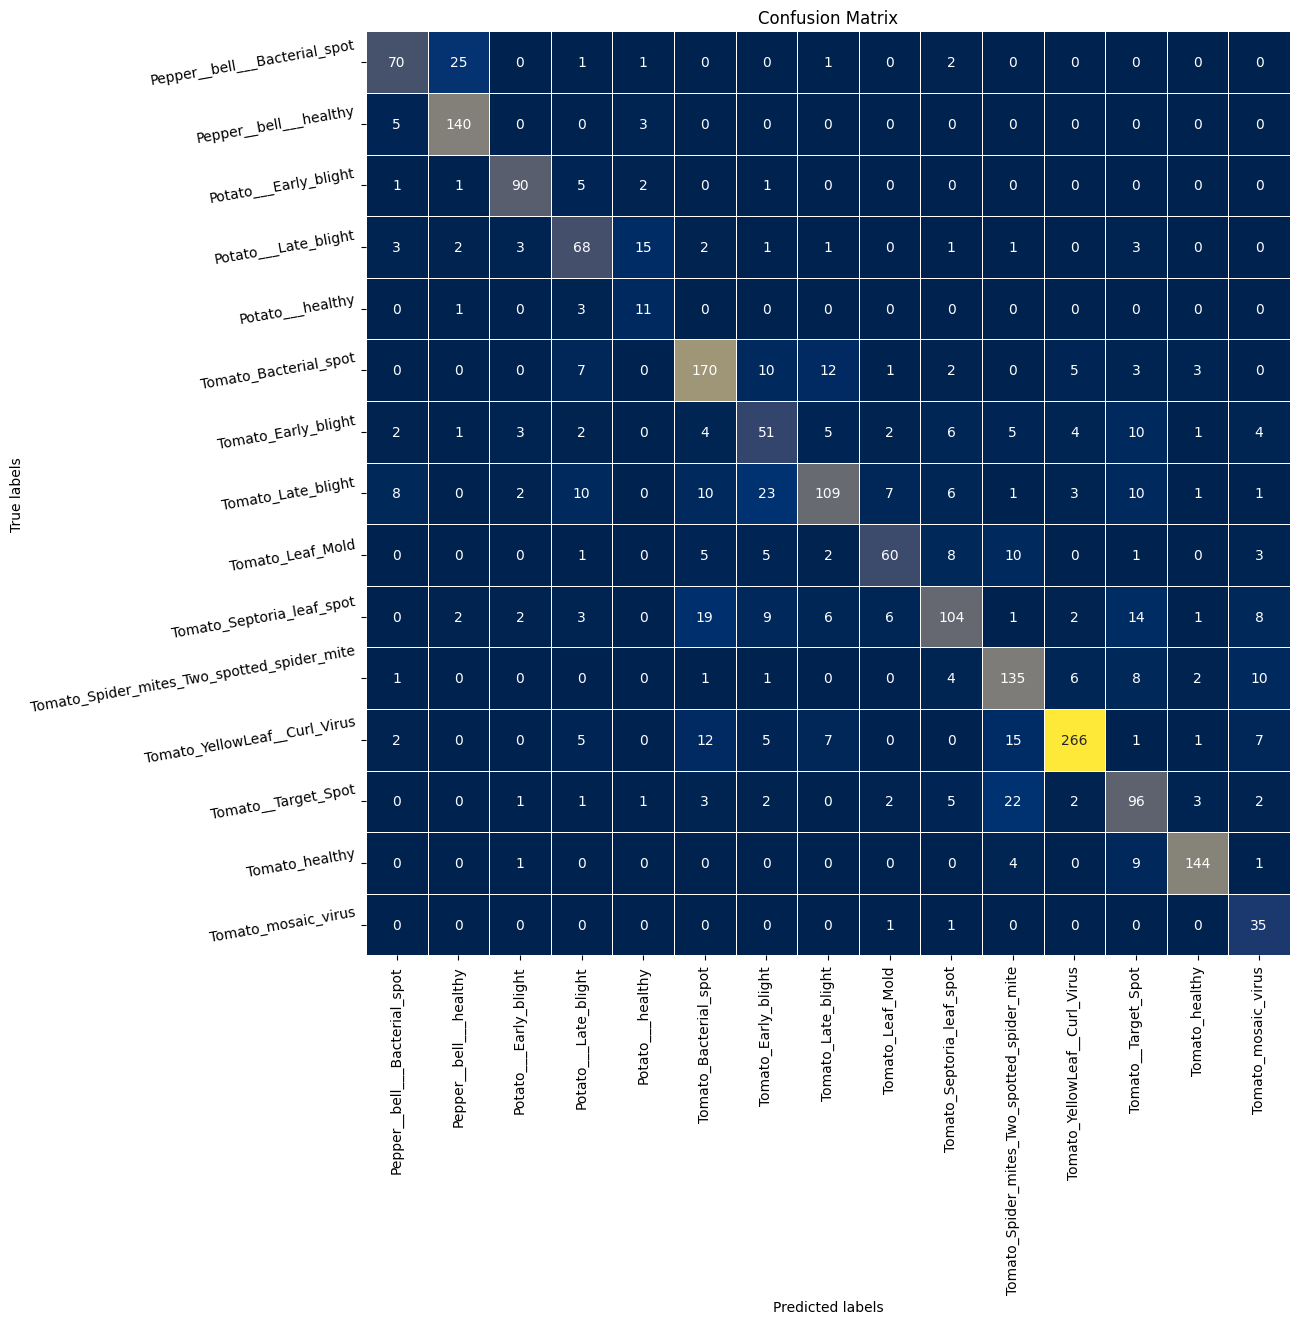

In [ ]:
# Predicting the test data
y_pred_model_agg=new_model_vgg.predict(X_test)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred_model_agg,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
cm_vgg = confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    cm_vgg,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,cmap='cividis',
    ax=ax,cbar=False
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=10)
plt.savefig(os.path.join(directory_root, 'confusion_matrix_vgg.png'))
plt.show()


In [ ]:
cr=classification_report(y_test_arg,y_pred_arg,target_names=enc.classes_,output_dict=False  )
print(cr)

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.76      0.70      0.73       100
                     Pepper__bell___healthy       0.81      0.95      0.88       148
                      Potato___Early_blight       0.88      0.90      0.89       100
                       Potato___Late_blight       0.64      0.68      0.66       100
                           Potato___healthy       0.33      0.73      0.46        15
                      Tomato_Bacterial_spot       0.75      0.80      0.77       213
                        Tomato_Early_blight       0.47      0.51      0.49       100
                         Tomato_Late_blight       0.76      0.57      0.65       191
                           Tomato_Leaf_Mold       0.76      0.63      0.69        95
                  Tomato_Septoria_leaf_spot       0.75      0.59      0.66       177
Tomato_Spider_mites_Two_spotted_spider_mite       0.70      0.80

#### results AGG

In [ ]:
# to dataframe and csv
cr_vgg=classification_report(y_test_arg,y_pred_arg,target_names=enc.classes_,output_dict=True  )
def confusion_matrix_to_dataframe(confusion_matrix, model_name):
    df = pd.DataFrame(confusion_matrix, columns=enc.classes_)
    df.index =enc.classes_
    df['Model'] = model_name
    return df
df_agg_confusion = confusion_matrix_to_dataframe(cm_vgg, 'AGG_model')
df_agg_confusion.to_csv(os.path.join(directory_root, 'confusion_matrix_agg.csv'))
# classificaiton model
df_agg_report = pd.DataFrame(cr_vgg).T
df_agg_report.to_csv(os.path.join(directory_root, 'classification_report_agg.csv'))

In [ ]:
#df_agg_report

#DenseNet:
![](https://www.researchgate.net/profile/Zhang_Li19/publication/323143806/figure/fig2/AS:614246022909961@1523459072596/Demonstration-of-Densenet-121-used-in-our-system.png)

### DenseNet-121 is a specific convolutional neural network (CNN) architecture and a member of the Dense Convolutional Network (DenseNet) family. It's known for its densely connected layers and its effectiveness in various computer vision tasks. Here's an explanation of DenseNet-121:

1. **Densely Connected Layers**: DenseNet-121 gets its name from its densely connected layers. Unlike traditional CNN architectures, where each layer connects only to the subsequent layer, DenseNet has a unique architecture where each layer connects to all subsequent layers. This dense connectivity promotes feature reuse, making it highly efficient in terms of parameter usage.

2. **Growth Rate**: DenseNet-121 employs a parameter known as the "growth rate." The growth rate determines how many new feature maps each layer in the network contributes. It's typically set to a small number (e.g., 32 or 64). This allows the model to efficiently add new features while keeping the overall model size manageable.

3. **Bottleneck Layers**: To further reduce the number of parameters, DenseNet-121 uses bottleneck layers. These layers reduce the number of channels before expanding them. This design choice helps maintain a balance between model capacity and computational efficiency.

4. **Transition Layers**: DenseNet-121 includes transition layers, which consist of convolutional and pooling layers. These layers reduce the spatial dimensions of feature maps and channel dimensions, helping to manage the model's complexity.

5. **Efficiency and Feature Reuse**: DenseNet-121's architecture encourages feature reuse, meaning that information learned in earlier layers is directly used by subsequent layers. This minimizes the risk of vanishing gradients and enables more efficient training.




In [ ]:
# try another pretrained model DenseNet121
from keras.applications import DenseNet121
# Clearing backend
backend.clear_session()
np.random.seed(42)

In [ ]:
# Get the Resnet model so we can do transfer learning
dense_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (128,128,3))

for layer in dense_model.layers[:]:
    layer.trainable = False
# Initializing the model
new_model_dense = Sequential()
# Adding the convolutional part of the VGG16 model from above
new_model_dense.add(dense_model)
new_model_dense.add(GlobalAveragePooling2D())
new_model_dense.add(Dense(64, activation='relu'))
# Complete the code to add dropout with dropout_rate=0.2
new_model_dense.add(Dropout(0.1))
new_model_dense.add(Dense(32, activation='relu'))
# Complete the code to add dropout with dropout_rate=0.2
new_model_dense.add(Dropout(0.1))
# Complete the code to add the output layer with 15 neurons and activation functions as softmax since this is a multi-class classification problem
new_model_dense.add(Dense(15, activation='softmax'))
# Compiling the model
new_model_dense.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Summary of the model
new_model_dense.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
model_checkpoint = ModelCheckpoint(
    'dense_model.h5',  # Specify the file name for the saved model
    monitor='val_accuracy',  # Choose the metric to monitor (e.g., validation accuracy)
    save_best_only=True,  # Save only the best model based on the monitored metric
    mode='max',  # 'max' if monitoring accuracy, 'min' if monitoring loss
    verbose=1  # Display messages when the model is saved
)

In [ ]:
history_dense = new_model_dense.fit(train_datagen.flow(X_train,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train.shape[0] // batch_size,
                                       validation_data=(X_val,y_val_encoded),
                                       verbose=2,
                        #callbacks=[learning_rate_reduction,early_stopping,model_checkpoint],
                        callbacks=[learning_rate_reduction,early_stopping],

                        class_weight=class_weights
                        )

Epoch 1/30
130/130 - 63s - loss: 1.7827 - accuracy: 0.4121 - val_loss: 1.1214 - val_accuracy: 0.6459 - lr: 0.0010 - 63s/epoch - 483ms/step
Epoch 2/30
130/130 - 54s - loss: 0.9923 - accuracy: 0.6611 - val_loss: 0.8162 - val_accuracy: 0.7304 - lr: 0.0010 - 54s/epoch - 416ms/step
Epoch 3/30
130/130 - 54s - loss: 0.8097 - accuracy: 0.7214 - val_loss: 0.7197 - val_accuracy: 0.7713 - lr: 0.0010 - 54s/epoch - 415ms/step
Epoch 4/30
130/130 - 55s - loss: 0.6961 - accuracy: 0.7563 - val_loss: 0.7178 - val_accuracy: 0.7653 - lr: 0.0010 - 55s/epoch - 420ms/step
Epoch 5/30
130/130 - 53s - loss: 0.6340 - accuracy: 0.7789 - val_loss: 0.6502 - val_accuracy: 0.7885 - lr: 0.0010 - 53s/epoch - 411ms/step
Epoch 6/30
130/130 - 54s - loss: 0.5802 - accuracy: 0.7960 - val_loss: 0.6447 - val_accuracy: 0.7836 - lr: 0.0010 - 54s/epoch - 413ms/step
Epoch 7/30
130/130 - 53s - loss: 0.5429 - accuracy: 0.8126 - val_loss: 0.6228 - val_accuracy: 0.7955 - lr: 0.0010 - 53s/epoch - 410ms/step
Epoch 8/30
130/130 - 54s - 

In [ ]:
pd.DataFrame(history_dense.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy/loss')
plt.show()


65/65 [==============================] - 2s 34ms/step


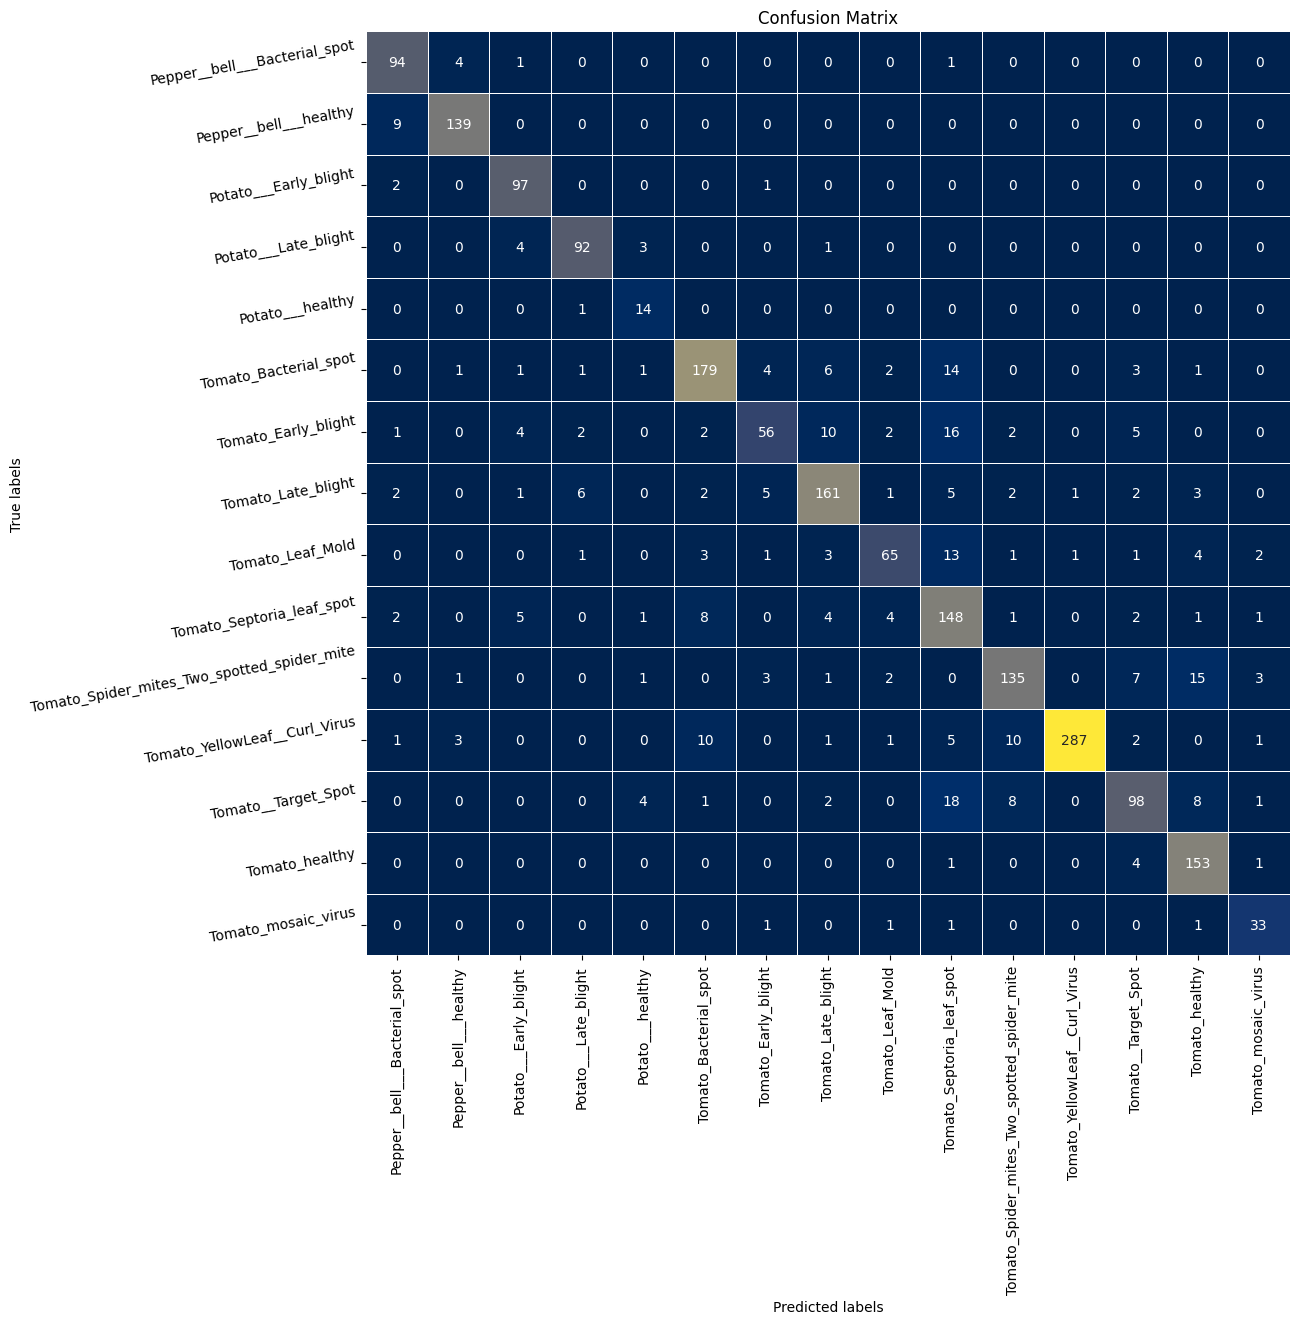

In [ ]:
# Predicting the test data
y_pred_model_dense=new_model_dense.predict(X_test)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred_model_dense,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
cm_dense = confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    cm_dense,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,cmap='cividis',
    ax=ax,cbar=False
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=10)
plt.savefig(os.path.join(directory_root, 'confusion_matrix_dense.png'))
plt.show()

In [ ]:
cr=classification_report(y_test_arg,y_pred_arg,target_names=enc.classes_,output_dict=False)     # Complete the code to plot the classification report
print(cr)

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.85      0.94      0.89       100
                     Pepper__bell___healthy       0.94      0.94      0.94       148
                      Potato___Early_blight       0.86      0.97      0.91       100
                       Potato___Late_blight       0.89      0.92      0.91       100
                           Potato___healthy       0.58      0.93      0.72        15
                      Tomato_Bacterial_spot       0.87      0.84      0.86       213
                        Tomato_Early_blight       0.79      0.56      0.65       100
                         Tomato_Late_blight       0.85      0.84      0.85       191
                           Tomato_Leaf_Mold       0.83      0.68      0.75        95
                  Tomato_Septoria_leaf_spot       0.67      0.84      0.74       177
Tomato_Spider_mites_Two_spotted_spider_mite       0.85      0.80

#### Result Dense

In [ ]:
# to dataframe and csv
cr_dense=classification_report(y_test_arg,y_pred_arg,target_names=enc.classes_,output_dict=True  )
def confusion_matrix_to_dataframe(confusion_matrix, model_name):
    df = pd.DataFrame(confusion_matrix, columns=enc.classes_)
    df.index =enc.classes_
    df['Model'] = model_name
    return df
df_dense_confusion = confusion_matrix_to_dataframe(cm_dense, 'densenet_model')
df_dense_confusion.to_csv(os.path.join(directory_root, 'confusion_matrix_dense.csv'))
# classificaiton model
df_dense_report = pd.DataFrame(cr_dense).T
df_dense_report.to_csv(os.path.join(directory_root, 'classification_report_dense.csv'))

# Xception:
###Xception is a deep convolutional neural network architecture that was introduced by François Chollet, the creator of the Keras deep learning framework, in a research paper titled "Xception: Deep Learning with Depthwise Separable Convolutions." Xception is designed to address the challenges of training very deep neural networks while maintaining efficiency and improving performance in computer vision tasks.The name "Xception" is a combination of "Extreme Inception" because it builds upon the ideas of the Inception model. However, Xception introduces a key architectural change, replacing the traditional convolutional layers with depthwise separable convolutions.
![](https://www.researchgate.net/publication/360457717/figure/fig6/AS:1153638017843201@1652060145106/The-schematic-architecture-of-Xception-model.png)



Key characteristics of Xception:

1. **Depthwise Separable Convolutions**: Instead of using standard convolution operations that combine spatial convolution and depthwise convolution (cross-channel correlations), Xception employs depthwise separable convolutions. Depthwise separable convolutions consist of two separate operations: depthwise convolution (a spatial convolution for each input channel separately) and pointwise convolution (a 1x1 convolution that combines the results of the depthwise convolution). This approach significantly reduces the number of parameters while capturing spatial and cross-channel information effectively.

2. **Fine-Grained Feature Learning**: Depthwise separable convolutions enable the network to capture fine-grained features in the early layers and learn increasingly abstract and complex features in deeper layers.

3. **Efficiency**: Xception is known for its computational efficiency, which makes it suitable for deployment on resource-constrained devices and real-time applications.

4. **State-of-the-Art Performance**: Xception achieved state-of-the-art performance in image classification tasks, including the ImageNet Large Scale Visual Recognition Challenge. It demonstrated the capability of deep neural networks to achieve high accuracy while remaining computationally efficient.



In [ ]:
# try another pretrained model DenseNet121
from tensorflow.keras.applications import Xception
# Clearing backend
backend.clear_session()
np.random.seed(42)

In [ ]:
# Get the Resnet model so we can do transfer learning
incept_model = Xception(weights='imagenet', include_top=False,input_shape= (128,128,3))


In [ ]:
incept_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 63, 63, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 63, 63, 32)           0         ['block1_conv1_bn[0][0]

In [ ]:
for layer in incept_model.layers[:]:
    layer.trainable = False
# Initializing the model
new_model_incept = Sequential()
# Adding the convolutional part of the VGG16 model from above
new_model_incept.add(incept_model)
new_model_incept.add(GlobalAveragePooling2D())
new_model_incept.add(Dense(64, activation='relu'))
# Complete the code to add dropout with dropout_rate=0.2
new_model_incept.add(Dropout(0.1))
new_model_incept.add(Dense(32, activation='relu'))
# Complete the code to add dropout with dropout_rate=0.2
new_model_incept.add(Dropout(0.1))
# Complete the code to add the output layer with 15 neurons and activation functions as softmax since this is a multi-class classification problem
new_model_incept.add(Dense(15, activation='softmax'))
# Compiling the model
new_model_incept.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Summary of the model
new_model_incept.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 64)                131136    
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                      

In [ ]:
history_incept = new_model_incept.fit(train_datagen.flow(X_train,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train.shape[0] // batch_size,
                                       validation_data=(X_val,y_val_encoded),
                                       verbose=2,
                        callbacks=[learning_rate_reduction,early_stopping],

                        class_weight=class_weights
                        )

Epoch 1/30
130/130 - 61s - loss: 1.8079 - accuracy: 0.4226 - val_loss: 1.3601 - val_accuracy: 0.5899 - lr: 0.0010 - 61s/epoch - 469ms/step
Epoch 2/30
130/130 - 56s - loss: 1.1470 - accuracy: 0.6213 - val_loss: 1.0290 - val_accuracy: 0.6808 - lr: 0.0010 - 56s/epoch - 433ms/step
Epoch 3/30
130/130 - 56s - loss: 0.9775 - accuracy: 0.6770 - val_loss: 0.9343 - val_accuracy: 0.7104 - lr: 0.0010 - 56s/epoch - 430ms/step
Epoch 4/30
130/130 - 57s - loss: 0.8649 - accuracy: 0.7081 - val_loss: 0.9139 - val_accuracy: 0.7121 - lr: 0.0010 - 57s/epoch - 437ms/step
Epoch 5/30
130/130 - 57s - loss: 0.8015 - accuracy: 0.7261 - val_loss: 0.8381 - val_accuracy: 0.7363 - lr: 0.0010 - 57s/epoch - 435ms/step
Epoch 6/30
130/130 - 56s - loss: 0.7468 - accuracy: 0.7397 - val_loss: 0.7898 - val_accuracy: 0.7422 - lr: 0.0010 - 56s/epoch - 433ms/step
Epoch 7/30
130/130 - 56s - loss: 0.7080 - accuracy: 0.7545 - val_loss: 0.8358 - val_accuracy: 0.7304 - lr: 0.0010 - 56s/epoch - 427ms/step
Epoch 8/30
130/130 - 56s - 

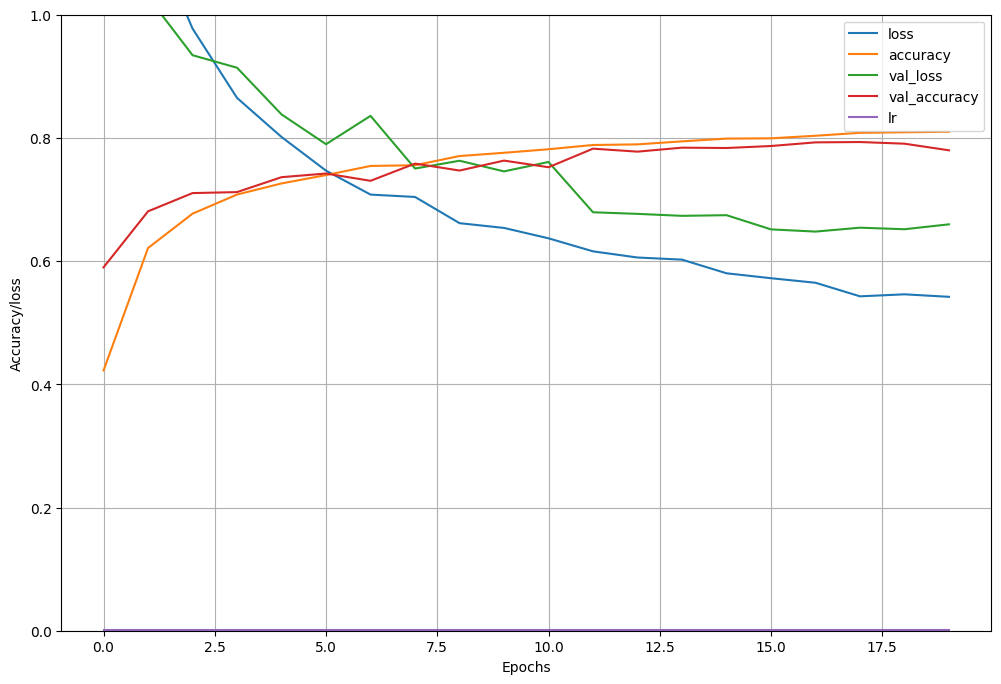

In [ ]:
pd.DataFrame(history_incept.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy/loss')
plt.show()


65/65 [==============================] - 3s 42ms/step


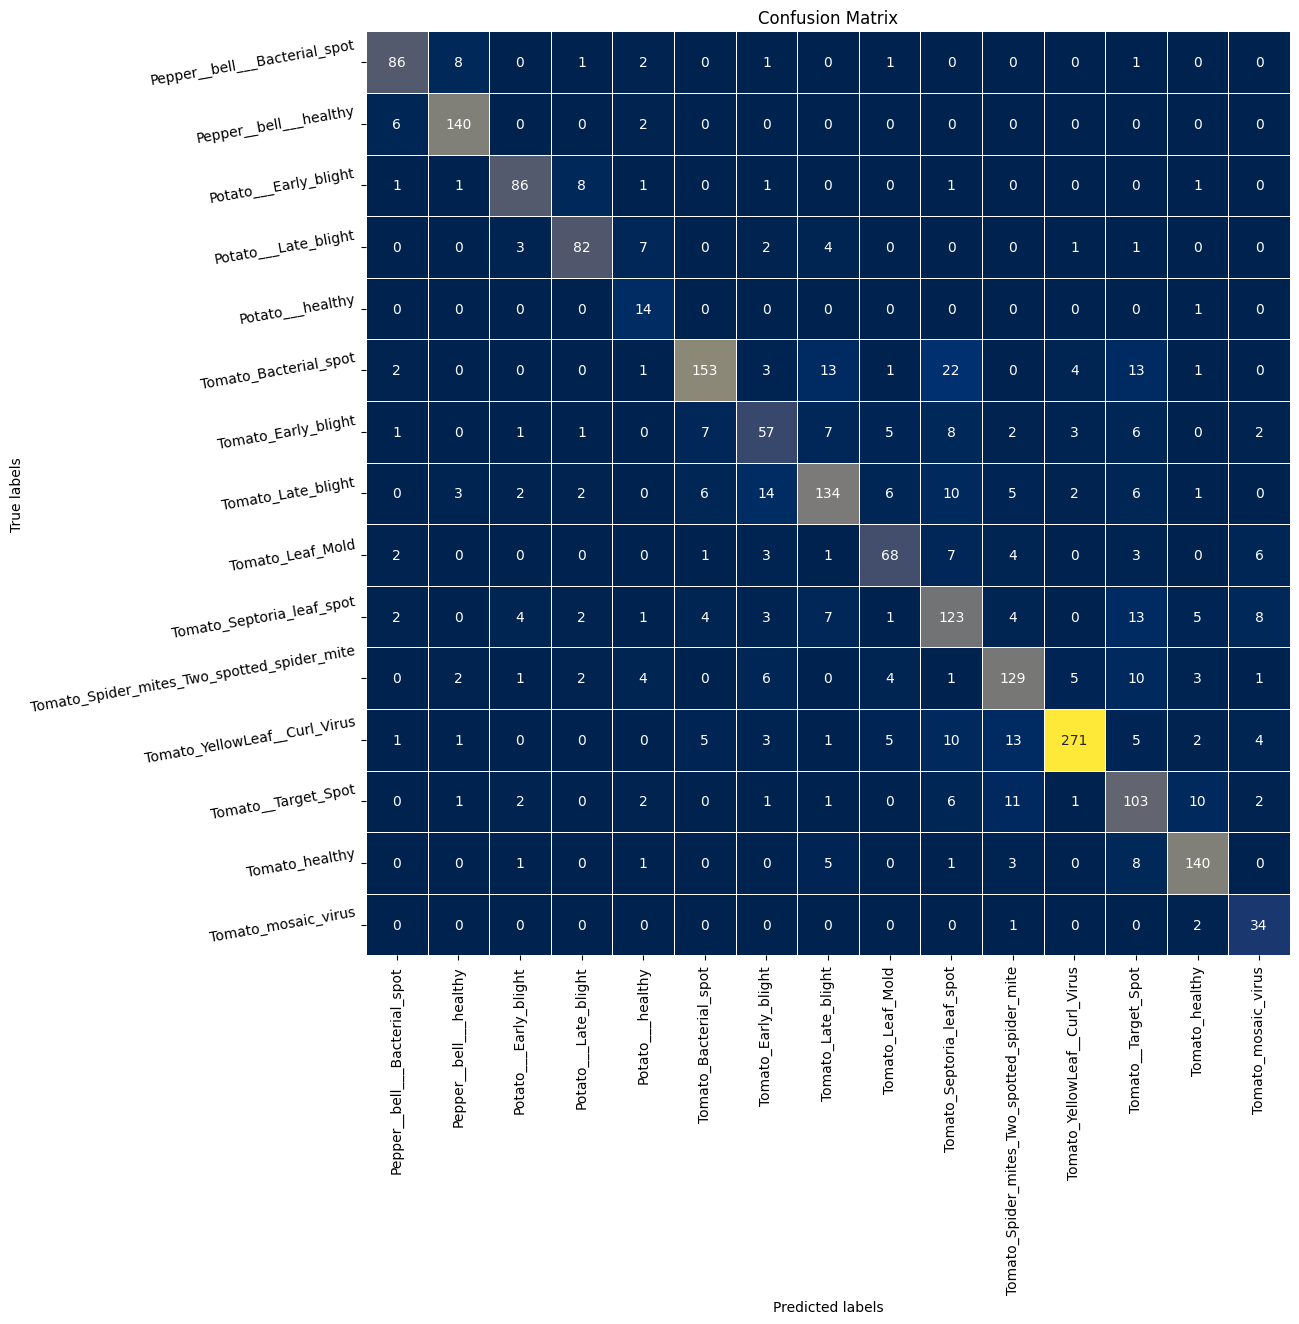

In [ ]:
# Predicting the test data
y_pred_model_incept=new_model_incept.predict(X_test)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred_model_incept,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
cm_incept = confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    cm_incept,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,cmap='cividis',
    ax=ax,cbar=False
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=10)
plt.savefig(os.path.join(directory_root, 'confusion_matrix_incept.png'))
plt.show()

'C:\\Users\\Rayan\\OneDrive\\GreatLearning_AI_with_DeepLearning\\Introduction_ComputerVision\\animal_detection_project\\PlantVillage\\confusion_matrix_incept.png'

In [ ]:
cr=classification_report(y_test_arg,y_pred_arg,target_names=enc.classes_,output_dict=False)     # Complete the code to plot the classification report
print(cr)

#### Result Xception

In [ ]:
# to dataframe and csv
cr_incept=classification_report(y_test_arg,y_pred_arg,target_names=enc.classes_,output_dict=True  )
def confusion_matrix_to_dataframe(confusion_matrix, model_name):
    df = pd.DataFrame(confusion_matrix, columns=enc.classes_)
    df.index =enc.classes_
    df['Model'] = model_name
    return df
df_xcept_confusion = confusion_matrix_to_dataframe(cm_incept, 'Xinception_model')
df_xcept_confusion.to_csv(os.path.join(directory_root, 'confusion_matrix_incept.csv'))
# classificaiton model
df_xcept_report = pd.DataFrame(cr_incept).T
df_xcept_report.to_csv(os.path.join(directory_root, 'classification_report_incept.csv'))

# Comparing the Results
## incase you want to run only this section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_context("talk")

directory_root='/content/drive/MyDrive/Colab Notebooks/Animal_Detection_YOLOv7/plant_disease_detection/'
class_table=pd.read_csv(os.path.join(directory_root, 'classification_report_agg.csv')).merge(pd.read_csv(os.path.join(directory_root, 'classification_report_dense.csv')),on='Unnamed: 0',suffixes=['','_DenseNet']).merge(pd.read_csv(os.path.join(directory_root, 'classification_report_incept.csv')),on='Unnamed: 0',suffixes=['_VGG16','_Xception']).iloc[:15,:]
class_table.set_index('Unnamed: 0',inplace=True)

In [ ]:
class_table.index=[i.replace('__','_').replace('___','_') for i in class_table.index]
class_table.index

Index(['Pepper_bell__Bacterial_spot', 'Pepper_bell__healthy',
       'Potato__Early_blight', 'Potato__Late_blight', 'Potato__healthy',
       'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight',
       'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
       'Tomato_Spider_mites_Two_spotted_spider_mite',
       'Tomato_YellowLeaf_Curl_Virus', 'Tomato_Target_Spot', 'Tomato_healthy',
       'Tomato_mosaic_virus'],
      dtype='object')

In [ ]:
recall=list(map(lambda x:x.startswith('recall'),class_table.columns.tolist()))
precision=list(map(lambda x:x.startswith('precision'),class_table.columns.tolist()))
f1=list(map(lambda x:x.startswith('f1'),class_table.columns.tolist()))

class_table[class_table.columns[recall]]

,recall_VGG16,recall_DenseNet,recall_Xception
Pepper_bell__Bacterial_spot,0.700000,0.940000,0.860000
Pepper_bell__healthy,0.945946,0.939189,0.945946
Potato__Early_blight,0.900000,0.970000,0.860000
Potato__Late_blight,0.680000,0.920000,0.820000
Potato__healthy,0.733333,0.933333,0.933333
Tomato_Bacterial_spot,0.798122,0.840376,0.718310
Tomato_Early_blight,0.510000,0.560000,0.570000
Tomato_Late_blight,0.570681,0.842932,0.701571
Tomato_Leaf_Mold,0.631579,0.684211,0.715789
Tomato_Septoria_leaf_spot,0.587571,0.836158,0.694915


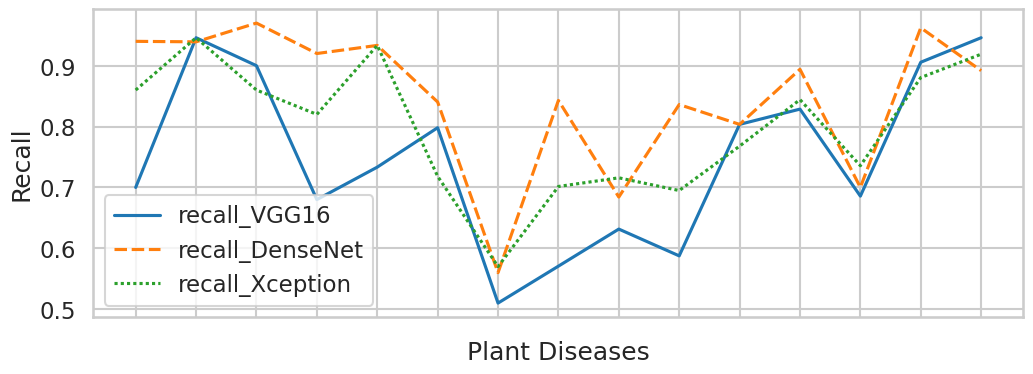

In [ ]:
plt.figure(figsize=(12,4))
ax=sns.lineplot(data=class_table[class_table.columns[recall]])
ax.set_xticklabels('')
ax.set_xlabel('Plant Diseases')
ax.set_ylabel('Recall')
plt.savefig(os.path.join(directory_root, 'recall.png'))

plt.show()

In [ ]:
class_table[class_table.columns[precision]]

,precision_VGG16,precision_DenseNet,precision_Xception
Pepper_bell__Bacterial_spot,0.760870,0.846847,0.851485
Pepper_bell__healthy,0.813953,0.939189,0.897436
Potato__Early_blight,0.882353,0.858407,0.860000
Potato__Late_blight,0.641509,0.893204,0.836735
Potato__healthy,0.333333,0.583333,0.400000
Tomato_Bacterial_spot,0.752212,0.873171,0.869318
Tomato_Early_blight,0.472222,0.788732,0.606383
Tomato_Late_blight,0.762238,0.851852,0.774566
Tomato_Leaf_Mold,0.759494,0.833333,0.747253
Tomato_Septoria_leaf_spot,0.748201,0.666667,0.650794


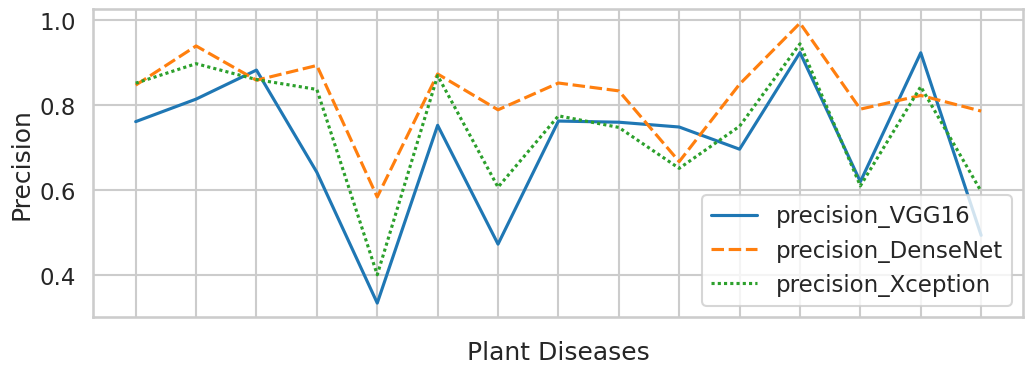

In [ ]:
plt.figure(figsize=(12,4))
ax=sns.lineplot(data=class_table[class_table.columns[precision]])
ax.set_xticklabels('')
ax.set_xlabel('Plant Diseases')
ax.set_ylabel('Precision')

plt.savefig(os.path.join(directory_root, 'precision.png'))

plt.show()

In [ ]:
class_table[class_table.columns[f1]]

,f1-score_VGG16,f1-score_DenseNet,f1-score_Xception
Pepper_bell__Bacterial_spot,0.729167,0.890995,0.855721
Pepper_bell__healthy,0.875000,0.939189,0.921053
Potato__Early_blight,0.891089,0.910798,0.860000
Potato__Late_blight,0.660194,0.906404,0.828283
Potato__healthy,0.458333,0.717949,0.560000
Tomato_Bacterial_spot,0.774487,0.856459,0.786632
Tomato_Early_blight,0.490385,0.654971,0.587629
Tomato_Late_blight,0.652695,0.847368,0.736264
Tomato_Leaf_Mold,0.689655,0.751445,0.731183
Tomato_Septoria_leaf_spot,0.658228,0.741855,0.672131


<ipython-input-47-934478d3fa5e>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=1)


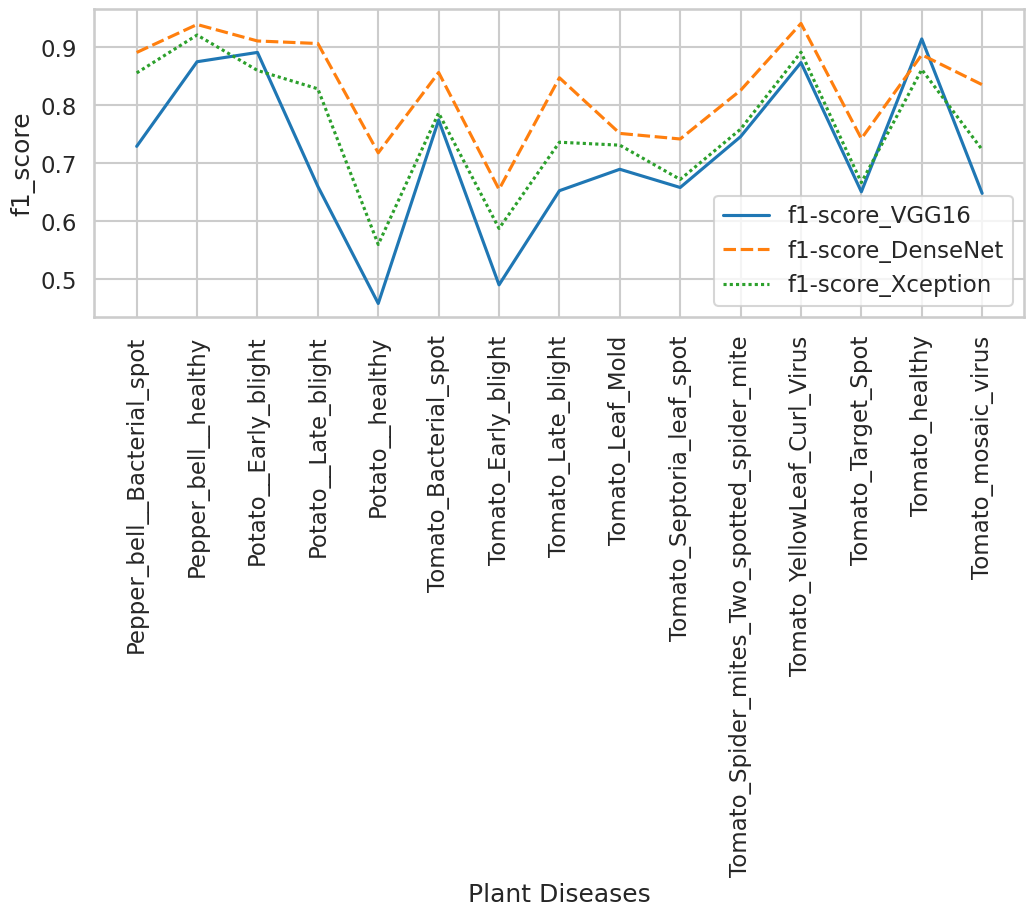

In [ ]:
plt.figure(figsize=(12,4))
sns.lineplot(data=class_table[class_table.columns[f1]])
plt.xticks(rotation=90)
plt.xlabel('Plant Diseases')
plt.ylabel( 'f1_score')
plt.savefig(os.path.join(directory_root, 'f1.png'),bbox_inches="tight")
plt.tight_layout(pad=1)
plt.show()

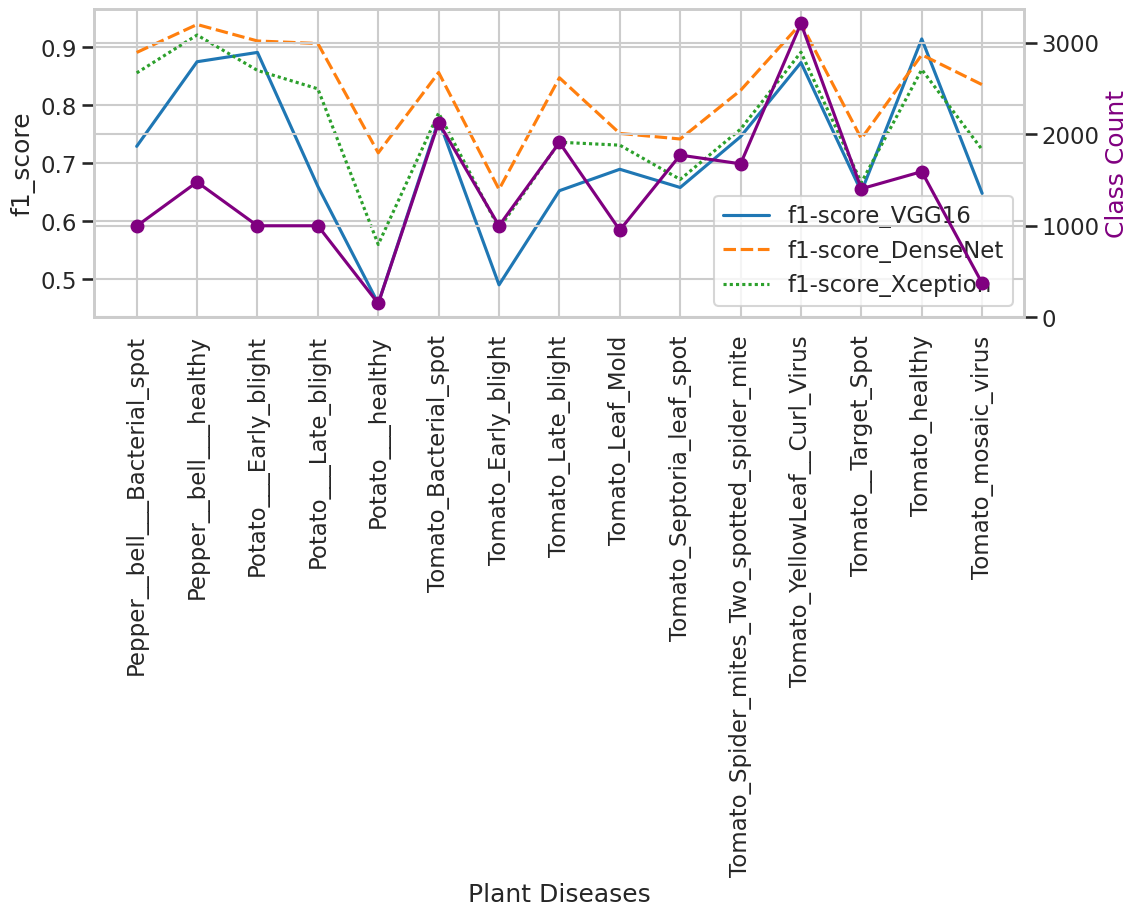

In [ ]:
# classe count
df=pd.DataFrame(num_values,index=['count']).T
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=class_table[class_table.columns[f1]],ax=ax)
plt.xticks(rotation=90)
ax.set_xlabel('Plant Diseases')
ax.set_ylabel( 'f1_score')
ax2 = ax.twinx()
# Plot the data for the second Y-axis (you can replace this with your own data)
ax2.plot(df, color='purple', marker='o')
# Set labels for the second Y-axis
ax2.set_ylabel('Class Count', color='purple')
plt.savefig(os.path.join(directory_root, 'f1_count.png'),bbox_inches="tight")
#plt.tight_layout()
plt.show()

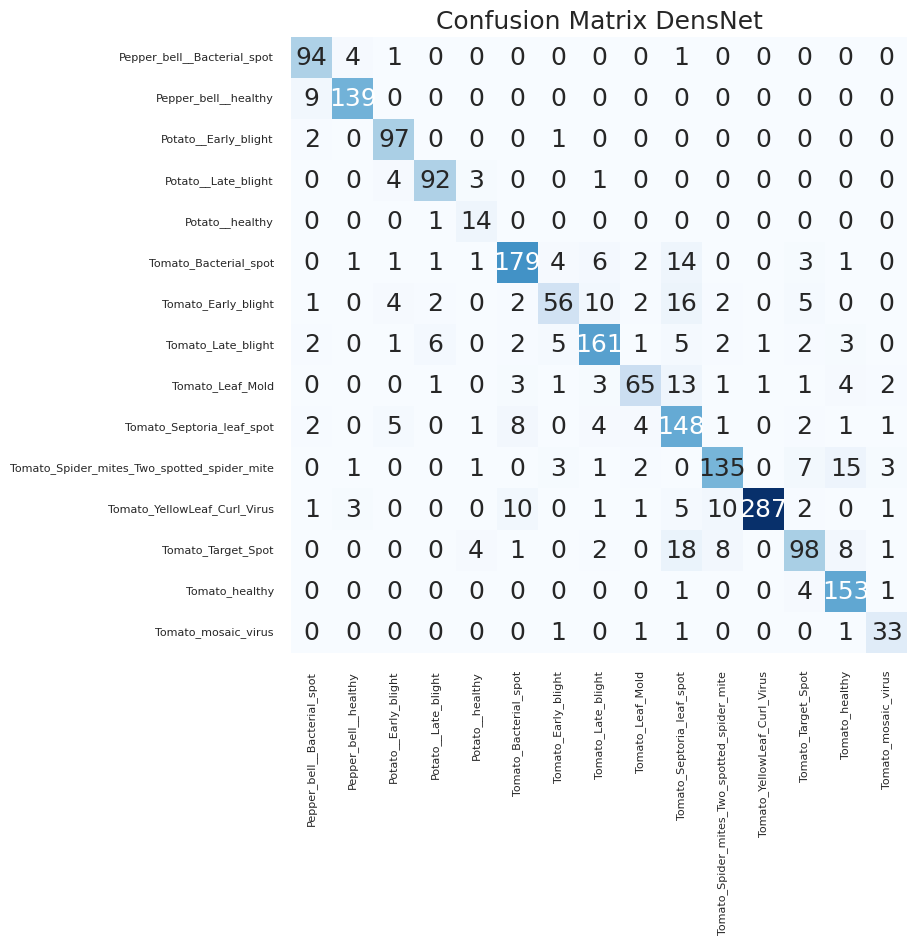

In [ ]:
cm_dense=pd.read_csv(os.path.join(directory_root, 'confusion_matrix_dense.csv'))
cm_dense.drop('Model',inplace=True,axis=1)
cm_dense.set_index('Unnamed: 0',inplace=True)
cm_dense.rename(columns={'Unnamed: 0':'Plant_Disease'},inplace=True)
cm_dense.rename(index={'Unnamed: 0':'Plant_Disease'},inplace=True)
cm_dense.index=[i.replace('__','_').replace('___','_') for i in cm_dense.index]
cm_dense.columns=[i.replace('__','_').replace('___','_') for i in cm_dense.columns]
plt.figure(figsize=(10, 8))
ax=sns.heatmap(cm_dense, annot=True, square=True, fmt='d', cmap="Blues",cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.xlabel('')
plt.ylabel('')
plt.title('Confusion Matrix DensNet')
plt.savefig(os.path.join(directory_root, 'confusion_matrix_DenseNet.png'))
plt.show()


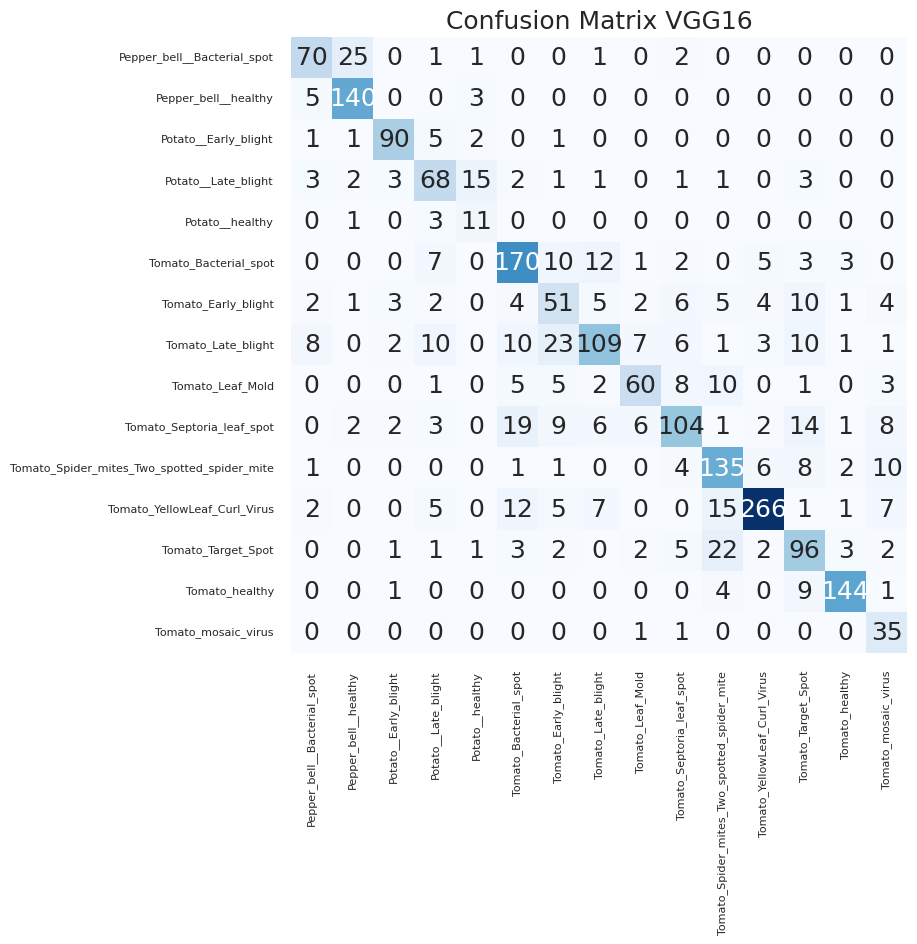

In [ ]:

cm_agg=pd.read_csv(os.path.join(directory_root, 'confusion_matrix_agg.csv'))
cm_agg.drop('Model',inplace=True,axis=1)
cm_agg.set_index('Unnamed: 0',inplace=True)
cm_agg.rename(columns={'Unnamed: 0':'Plant_Disease'},inplace=True)
cm_agg.rename(index={'Unnamed: 0':'Plant_Disease'},inplace=True)
cm_agg.index=[i.replace('__','_').replace('___','_') for i in cm_agg.index]
cm_agg.columns=[i.replace('__','_').replace('___','_') for i in cm_agg.columns]
plt.figure(figsize=(10, 8))
ax=sns.heatmap(cm_agg, annot=True, square=True, fmt='d', cmap="Blues",cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.xlabel('')
plt.ylabel('')
plt.title('Confusion Matrix VGG16')
plt.savefig(os.path.join(directory_root, 'confusion_matrix_vgg16.png'))
plt.show()


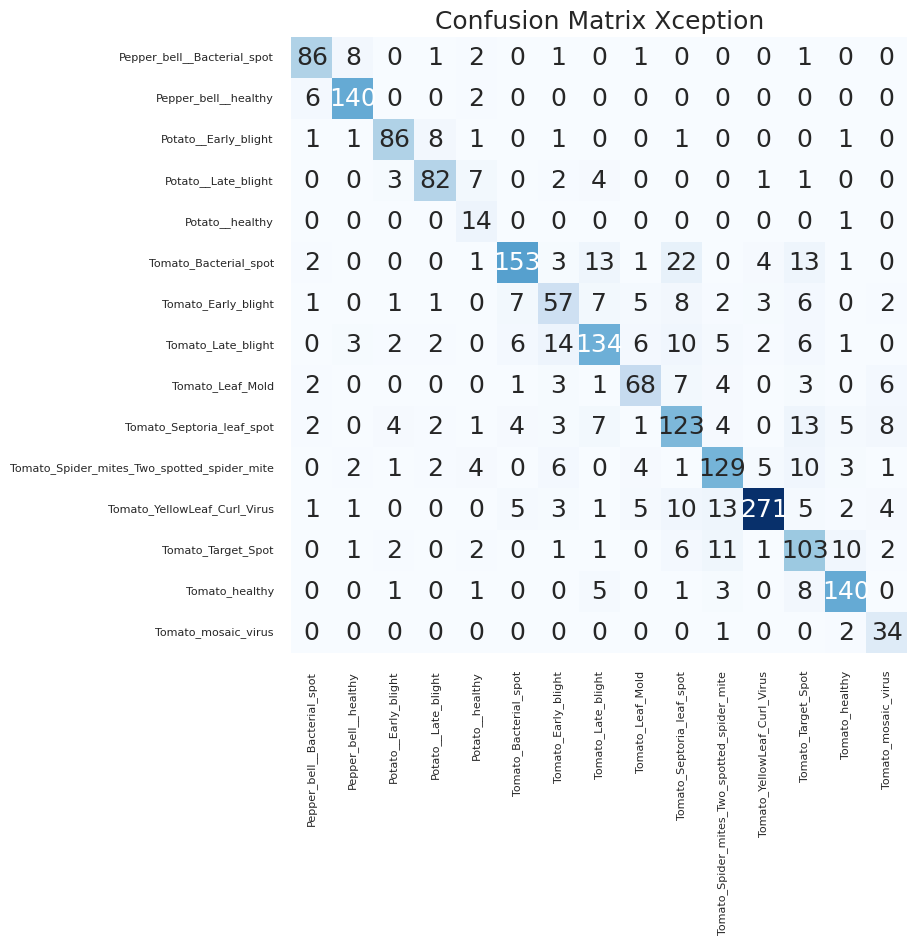

In [ ]:
cm_incept=pd.read_csv(os.path.join(directory_root, 'confusion_matrix_incept.csv'))
cm_incept.drop('Model',inplace=True,axis=1)
cm_incept.set_index('Unnamed: 0',inplace=True)
cm_incept.rename(columns={'Unnamed: 0':'Plant_Disease'},inplace=True)
cm_incept.rename(index={'Unnamed: 0':'Plant_Disease'},inplace=True)
cm_incept.index=[i.replace('__','_').replace('___','_') for i in cm_incept.index]
cm_incept.columns=[i.replace('__','_').replace('___','_') for i in cm_incept.columns]
plt.figure(figsize=(10, 8))
ax=sns.heatmap(cm_incept, annot=True, square=True, fmt='d', cmap="Blues",cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.xlabel('')
plt.ylabel('')
plt.title('Confusion Matrix Xception')
plt.savefig(os.path.join(directory_root, 'confusion_matrix_incept.png'))
plt.show()


In [ ]:
import numpy as np
sns.set_style("ticks")
sns.set_context("paper" )

# Define the dimensions of the image
width = 15
height = 15
channels = 3  # Three color channels (R, G, B)

# Create an image with all zero values
image = np.zeros((height, width, channels), dtype=np.uint8)


image[:,:,0]=cm_agg.values#/np.max(cm_agg.values)
image[:,:,1]=cm_dense.values#/np.max(cm_dense.values)
image[:,:,2]=cm_incept.values#/np.max(cm_incept.values)


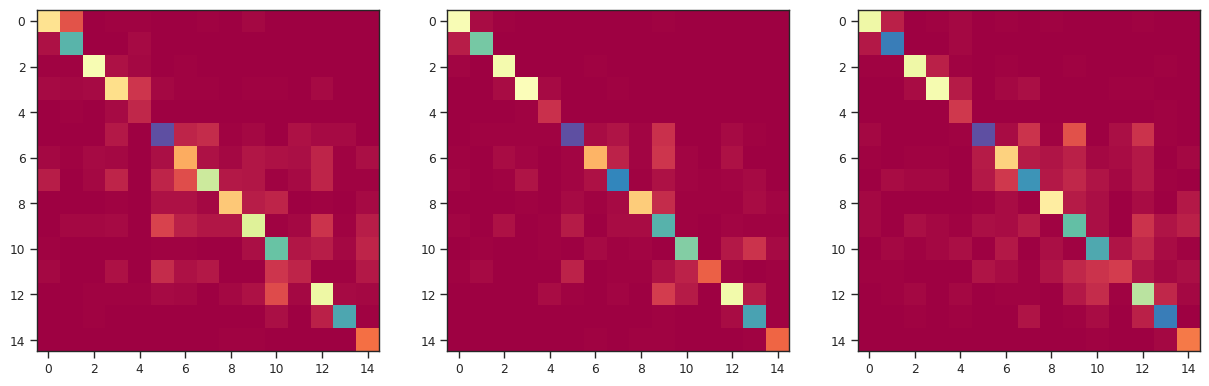

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(image[:,:,0]/np.max(image[:,:,0]),cmap='Spectral')
ax[1].imshow(image[:,:,1]/np.max(image[:,:,1]),cmap='Spectral')
ax[2].imshow(image[:,:,2]/np.max(image[:,:,2]),cmap='Spectral')

### Obs: DenseNet stands out as the model with the highest scores for many diseases, making it a robust choice for a wide range of plant disease classification tasks.